# Predicting Judicial Decisions of the European Court of Human Rights

In this notebook, we aim to train a classification model to classify cases as 'violation' or 'non-violation' using ULMFiT. 
The cases were originally downloaded from HUDOC and structured based on the articles they fall under.

In [1]:
from fastai import *
from fastai.text import *
from fastai.utils.mem import gpu_mem_get_free_no_cache
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import re
import os
import copy
import torch

To read our dataset, we use os.walk to walk through a sub-tree of directories and files and load all of our training data and labels. We avoid the folder 'both' as the files inside are labelled both as violation and non-violation.
Our data set will be loaded into dictionaries, the keys corresponding to articles and the values will be a list of cases (X - our training set) or labels (Y).

In [3]:
def read_dataset(PATH):
    X_dataset = {}
    Y_dataset = {}
    for path, dirs, files in os.walk(PATH):
        for filename in files:
            fullpath = os.path.join(path, filename)
            if "both" not in fullpath:
                with open(fullpath, 'r', encoding="utf8") as file:
                    X_dataset, Y_dataset = add_file_to_dataset(fullpath, X_dataset, Y_dataset, file.read())

    return X_dataset, Y_dataset       

In [4]:
def add_file_to_dataset(fullpath, x_dataset, y_dataset, file):
    article = extract_article(fullpath)
    file = preprocess(file)
    if article not in x_dataset.keys() :
        x_dataset[article] = []
        y_dataset[article] = []
    x_dataset[article] = x_dataset[article] + [file]
    label = 0 if "non-violation" in fullpath else 1
    y_dataset[article] = y_dataset[article] + [label]
    return x_dataset, y_dataset  

We use regex to extract the number of the Article from the fullpath and insert the file into the list under that specific Article.

In [5]:
def extract_article(path): 
    pattern = r"(Article\d+)"
    result = re.search(pattern, path)
    article = result.group(1)
    return article

### Preprocessing 

In [6]:
def preprocess(file): 
    file = extract_paragraphs(file)
    return file

In [7]:
def extract_paragraphs(file): 
    file = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', file)
    pat = r'(PROCEDURE\s*\n.+?)?((THE CIRCUMSTANCES OF THE CASE\s*\n.+?RELEVANT DOMESTIC LAW.+?)|(\n(AS TO THE FACTS|THE FACTS)\s*\n.+?))(\nIII\.|THE LAW\s*\n|PROCEEDINGS BEFORE THE COMMISSION\s*\n|ALLEGED VIOLATION OF ARTICLE [0-9]+ OF THE CONVENTION \s*\n)'
    result = re.search(pat, file, re.S |  re.IGNORECASE)
    if result is None:
        print(repr(file))
    content = ""
    if result.group(1) is not None:
        content += result.group(1)
    content += result.group(2)
    return content

### Loading the data

In [8]:
base_path = "Datasets\\Human rights dataset"

In [9]:
X_train_docs, Y_train_docs = read_dataset(base_path + "\\train")
#X_extra_test_docs, Y_extra_test = read_dataset(base_path + "\\test_violations")

In [10]:
X_train_docs.keys()

dict_keys(['Article10', 'Article11', 'Article12', 'Article13', 'Article14', 'Article18', 'Article2', 'Article3', 'Article4', 'Article5', 'Article6', 'Article7', 'Article8'])

Also, similarly to Medvedeva, M., Vols, M. & Wieling, M. Artif Intell Law (2019), we want to remove the articles which contain too few cases. We include Article 11 "as an estimate of how well the model performs when only very few cases are available".

In [11]:
def select_articles(train_set):
    selected_training_set = copy.deepcopy(train_set)
    
    for key in train_set.keys():
        if len(train_set[key]) <= 50:
            selected_training_set.pop(key)
            continue
    return selected_training_set

In [12]:
X_train_docs = select_articles(X_train_docs)

In [13]:
X_train_docs.keys()

dict_keys(['Article10', 'Article11', 'Article13', 'Article14', 'Article2', 'Article3', 'Article5', 'Article6', 'Article8'])

### Combining all the articles according to class

In [14]:
X_train = X_train_docs["Article2"] + X_train_docs["Article3"] + X_train_docs["Article5"] + X_train_docs["Article6"] + X_train_docs["Article8"] + X_train_docs["Article10"] + X_train_docs["Article11"] + X_train_docs["Article13"] + X_train_docs["Article14"]

In [15]:
print(str(len(X_train_docs["Article2"])) + "+" + str(len(X_train_docs["Article3"])) + "+" + str(len(X_train_docs["Article5"])) + "+" + str(len(X_train_docs["Article6"])) + "+" + str(len(X_train_docs["Article8"])) + "+" + str(len(X_train_docs["Article10"])) + "+" + str(len(X_train_docs["Article11"])) + "+" + str(len(X_train_docs["Article13"])) + "+" + str(len(X_train_docs["Article14"])) + "=" + str(len(X_train)))

114+568+300+916+457+212+64+212+288=3131


In [16]:
Y_train = Y_train_docs["Article2"] + Y_train_docs["Article3"] + Y_train_docs["Article5"] + Y_train_docs["Article6"] + Y_train_docs["Article8"] + Y_train_docs["Article10"] + Y_train_docs["Article11"] + Y_train_docs["Article13"] + Y_train_docs["Article14"]

In [17]:
len(Y_train)

3131

### Creating the Language Model and Classifier DataBunches

Credit to FastAi for explaining and providing the code (https://github.com/fastai/course-nlp/blob/master/5-nn-imdb.ipynb)

In [3]:
path = os.getcwd()

In [19]:
cases = {'Case': X_train, 'Label': Y_train}

In [20]:
df = DataFrame(cases, columns= ['Case', 'Label'])
df.head()

,Case,Label
0,PROCEDURE\n1.The case originated in an applica...,0
1,PROCEDURE\n1.The case originated in an applica...,0
2,PROCEDURE\n1.The case originated in an applica...,0
3,PROCEDURE\n1.The case originated in an applica...,0
4,PROCEDURE\n1.The case originated in an applica...,0


In [21]:
train_df, valid_df = train_test_split(df, test_size=0.1)

In [22]:
print(train_df.iloc[0,0])

PROCEDURE
1.The case originated in an application (no. 8139/09) against the UnitedKingdom of Great Britain and Northern Ireland lodged with the Court under Article 34 of the Convention for the Protection of Human Rights and Fundamental Freedoms (“the Convention”) by a Jordanian national, Mr Omar Othman (“the applicant”), on 11 February 2009.
2.The applicant was represented by Ms G. Peirce a lawyer practising in London with Birnberg Peirce & Partners. She was assisted by MrE.Fitzgerald QC, Mr R. Husain QC and Mr D. Friedman, counsel. The United Kingdom Government (“the Government”) were represented by their Agent, MsL.Dauban, of the Foreign and Commonwealth Office.
3.The applicant alleged, in particular, that he would be at real risk of illtreatment contrary to Article 3 of the Convention, and a flagrant denial of justice, contrary to Article 6 of the Convention, if he were deported to Jordan.
4.On 19 February 2009 the President of the Chamber to which the application had been allocated

75.Jordan’s assurances were also found to be compatible with Article 3 in VV (2 November 2007). SIAC took note of further reports on torture in Jordanian prisons and considered that those reports confirmed its view that, without the MOU, there was a real risk of ill-treatment. However, those reports did not alter its conclusions in the present case that the MOU and Adaleh’s monitoring role provided sufficient protection.


In [23]:
data_lm = TextLMDataBunch.from_df(path, train_df = train_df, valid_df = valid_df, text_cols = 0, bs=32)

In [24]:
data_clas = TextClasDataBunch.from_df(path, train_df = train_df, valid_df = valid_df, vocab=data_lm.train_ds.vocab, text_cols = 0, label_cols = 1, bs=32)

In [25]:
data_lm.show_batch()

idx,text
0,"xxmaj mr xxmaj omar xxmaj othman ( “ the applicant ” ) , on 11 xxmaj february 2009 . \n 2.the applicant was represented by xxmaj ms xxup g. xxmaj peirce a lawyer practising in xxmaj london with xxmaj birnberg xxmaj peirce & xxmaj partners . xxmaj she was assisted by mre.fitzgerald xxup qc , xxmaj mr xxup r. xxmaj husain xxup qc and xxmaj mr xxup d. xxmaj"
1,"of xxmaj captain xxup s. , the officer in command of the servicemen involved in the incident of 27 xxmaj october 2001 . xxmaj thereafter the investigation was reopened on 23 xxmaj october 2004 and 7 xxmaj may 2005 and discontinued in application of an amnesty act on 7 xxmaj april and 21july 2005 respectively . \n 62.the report also states that the scene of the incident was inspected"
2,returned [ for further investigation ] ... ” \n 81 . xxmaj on the same date the supervising prosecutor issued a decision ordering the investigation to take the following actions in the criminal case : \n “ 1 . xxmaj to make a plan of the investigative and operational search measures ... \n 2 . xxmaj to establish the identity of eyewitnesses to xxmaj abu xxmaj khasuyev
3,"justified . \n 14.on 1 xxmaj october and 31 xxmaj december 2002 and 31 xxmaj march , 26 xxmaj june , 25september and 15 xxmaj december 2003 the xxmaj rostov xxmaj regional xxmaj court extended the applicant 's detention until 1 xxmaj january , 31 xxmaj march , 30 xxmaj june , 26 xxmaj september , 25 xxmaj december 2003 and 15 xxmaj march 2004 respectively . xxmaj the"
4,"xxmaj france , the xxmaj netherlands , the xxmaj united xxmaj kingdom , xxmaj spain and xxmaj canada . xxmaj her sister is living in xxmaj denmark . xxmaj after the applicant and her brother had left xxmaj iraq , their mother went to live with a xxmaj christian family in xxmaj baghdad , from whom she rented a room . xxmaj in the beginning of 2010 , the applicant"


#### Vocabulary

TextDataBunch does a number of things under the hood: tokenization and numericalization. Tokenization:
* the "'s" are grouped together in one token
* the contractions are separated like his: "did", "n't"
* content has been cleaned for any HTML symbol and lower cased
* there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

In [26]:
vocab = data_lm.vocab

In [27]:
len(vocab.itos)

60000

In [28]:
vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 'of',
 ',',
 '.',
 'to',
 'and',
 'in',
 '\n ',
 'a',
 'that',
 'on']

In [29]:
len(data_lm.train_ds)

2817

In [30]:
data_lm.save('data_lm_export_copy.pkl')
data_clas.save('data_clas_export_copy.pkl')

### Creating and Fine-tuning the Language Model

In [3]:
path = os.getcwd()

In [4]:
# bs=8
bs=16
# bs=32

In [5]:
data_lm = load_data(path, 'data_lm_export_copy.pkl', bs=bs)
data_clas = load_data(path, 'data_clas_export_copy.pkl', bs=bs)

In [6]:
torch.cuda.set_device(0)

In [7]:
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

In [8]:
gpu_mem_get_free_no_cache()

4021

In [9]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [10]:
learn_lm.model = learn_lm.model.cuda()


In [11]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


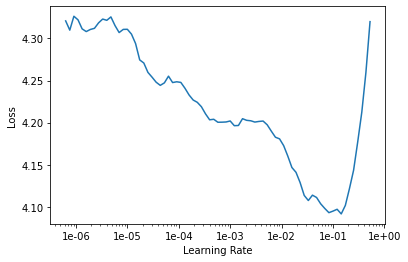

In [12]:
learn_lm.recorder.plot(skip_end=15)

In [13]:
lr = 1e-2
lr *= bs/48

In [14]:
learn_lm.to_fp16();

In [15]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.798289,3.291938,0.405469,1:26:41


In [16]:
learn_lm.save('fit_1_copy')

In [17]:
learn_lm.load('fit_1_copy')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2817 items)
x: LMTextList
xxbos xxup procedure 
  1.the case originated in an application ( no . 8139 / 09 ) against the unitedkingdom of xxmaj great xxmaj britain and xxmaj northern xxmaj ireland lodged with the xxmaj court under xxmaj article 34 of the xxmaj convention for the xxmaj protection of xxmaj human xxmaj rights and xxmaj fundamental xxmaj freedoms ( “ the xxmaj convention ” ) by a xxmaj jordanian national , xxmaj mr xxmaj omar xxmaj othman ( “ the applicant ” ) , on 11 xxmaj february 2009 . 
  2.the applicant was represented by xxmaj ms xxup g. xxmaj peirce a lawyer practising in xxmaj london with xxmaj birnberg xxmaj peirce & xxmaj partners . xxmaj she was assisted by mre.fitzgerald xxup qc , xxmaj mr xxup r. xxmaj husain xxup qc and xxmaj mr xxup d. xxmaj friedman , counsel . xxmaj the xxmaj united xxmaj kingdom xxmaj government ( “ the xxmaj government ” ) were represented by their xxmaj agent , msl.dauban , of the

In [18]:
learn_lm.unfreeze()

In [19]:
learn_lm.fit_one_cycle(3, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.113285,3.149671,0.429934,1:38:21
1,2.942779,2.838260,0.469248,1:39:51
2,2.844110,2.675513,0.494932,1:40:11


In [20]:
learn_lm.save('fit_2_copy')

In [21]:
learn_lm.load('fit_2_copy')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2817 items)
x: LMTextList
xxbos xxup procedure 
  1.the case originated in an application ( no . 8139 / 09 ) against the unitedkingdom of xxmaj great xxmaj britain and xxmaj northern xxmaj ireland lodged with the xxmaj court under xxmaj article 34 of the xxmaj convention for the xxmaj protection of xxmaj human xxmaj rights and xxmaj fundamental xxmaj freedoms ( “ the xxmaj convention ” ) by a xxmaj jordanian national , xxmaj mr xxmaj omar xxmaj othman ( “ the applicant ” ) , on 11 xxmaj february 2009 . 
  2.the applicant was represented by xxmaj ms xxup g. xxmaj peirce a lawyer practising in xxmaj london with xxmaj birnberg xxmaj peirce & xxmaj partners . xxmaj she was assisted by mre.fitzgerald xxup qc , xxmaj mr xxup r. xxmaj husain xxup qc and xxmaj mr xxup d. xxmaj friedman , counsel . xxmaj the xxmaj united xxmaj kingdom xxmaj government ( “ the xxmaj government ” ) were represented by their xxmaj agent , msl.dauban , of the

In [23]:
learn_lm.predict("I am suing you for", n_words=50, temperature=0.25)

"I am suing you for the purposes of the proceedings before the Court . The Court has established that the applicant was born in 1964 and lives in Moscow . \n  a.the applicant 's arrest and detention in Russia \n  1.the applicant 's arrest and detention \n  8.on 27"

In [24]:
learn_lm.predict("The Court finds you", n_words=40, temperature=0.75)

'The Court finds you to be in a position of interest in the proceedings . It has no factual reasons to see whether the facts of the case are in dispute . \n  B. The Government ’s observations \n  13.on'

In [25]:
learn_lm.load('fit_2_copy')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2817 items)
x: LMTextList
xxbos xxup procedure 
  1.the case originated in an application ( no . 8139 / 09 ) against the unitedkingdom of xxmaj great xxmaj britain and xxmaj northern xxmaj ireland lodged with the xxmaj court under xxmaj article 34 of the xxmaj convention for the xxmaj protection of xxmaj human xxmaj rights and xxmaj fundamental xxmaj freedoms ( “ the xxmaj convention ” ) by a xxmaj jordanian national , xxmaj mr xxmaj omar xxmaj othman ( “ the applicant ” ) , on 11 xxmaj february 2009 . 
  2.the applicant was represented by xxmaj ms xxup g. xxmaj peirce a lawyer practising in xxmaj london with xxmaj birnberg xxmaj peirce & xxmaj partners . xxmaj she was assisted by mre.fitzgerald xxup qc , xxmaj mr xxup r. xxmaj husain xxup qc and xxmaj mr xxup d. xxmaj friedman , counsel . xxmaj the xxmaj united xxmaj kingdom xxmaj government ( “ the xxmaj government ” ) were represented by their xxmaj agent , msl.dauban , of the

In [26]:
learn_lm.save('fine_tuned_copy')

In [27]:
learn_lm.save_encoder('fine_tuned_enc_copy')

### Classification

In [9]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn_c.load_encoder('fine_tuned_enc_copy')
learn_c.freeze()

In [10]:
learn_c.metrics= [accuracy,
               Precision(average='micro'),
               Recall(average='micro'),
               FBeta(average='micro')]

In [11]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


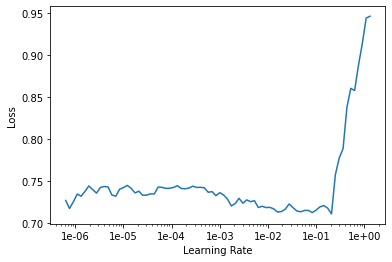

In [12]:
learn_c.recorder.plot()

In [11]:
learn_c.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.653699,0.585882,0.697452,0.697452,0.697452,0.697452,43:32


In [12]:
learn_c.save('first_copy')

In [11]:
learn_c.load('first_copy')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2817 items)
x: TextList
xxbos xxup procedure 
  1.the case originated in an application ( no . 8139 / 09 ) against the unitedkingdom of xxmaj great xxmaj britain and xxmaj northern xxmaj ireland lodged with the xxmaj court under xxmaj article 34 of the xxmaj convention for the xxmaj protection of xxmaj human xxmaj rights and xxmaj fundamental xxmaj freedoms ( “ the xxmaj convention ” ) by a xxmaj jordanian national , xxmaj mr xxmaj omar xxmaj othman ( “ the applicant ” ) , on 11 xxmaj february 2009 . 
  2.the applicant was represented by xxmaj ms xxup g. xxmaj peirce a lawyer practising in xxmaj london with xxmaj birnberg xxmaj peirce & xxmaj partners . xxmaj she was assisted by mre.fitzgerald xxup qc , xxmaj mr xxup r. xxmaj husain xxup qc and xxmaj mr xxup d. xxmaj friedman , counsel . xxmaj the xxmaj united xxmaj kingdom xxmaj government ( “ the xxmaj government ” ) were represented by their xxmaj agent , msl.dauban , of the xxma

In [12]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.625465,0.578356,0.726115,0.726115,0.726115,0.726115,48:05


In [13]:
learn_c.save('2nd_copy')

In [14]:
learn_c.load('2nd_copy')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2817 items)
x: TextList
xxbos xxup procedure 
  1.the case originated in an application ( no . 8139 / 09 ) against the unitedkingdom of xxmaj great xxmaj britain and xxmaj northern xxmaj ireland lodged with the xxmaj court under xxmaj article 34 of the xxmaj convention for the xxmaj protection of xxmaj human xxmaj rights and xxmaj fundamental xxmaj freedoms ( “ the xxmaj convention ” ) by a xxmaj jordanian national , xxmaj mr xxmaj omar xxmaj othman ( “ the applicant ” ) , on 11 xxmaj february 2009 . 
  2.the applicant was represented by xxmaj ms xxup g. xxmaj peirce a lawyer practising in xxmaj london with xxmaj birnberg xxmaj peirce & xxmaj partners . xxmaj she was assisted by mre.fitzgerald xxup qc , xxmaj mr xxup r. xxmaj husain xxup qc and xxmaj mr xxup d. xxmaj friedman , counsel . xxmaj the xxmaj united xxmaj kingdom xxmaj government ( “ the xxmaj government ” ) were represented by their xxmaj agent , msl.dauban , of the xxma

In [15]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.619466,0.575267,0.713376,0.713376,0.713376,0.713376,49:43


In [16]:
learn_c.save('3rd_copy')

In [ ]:
learn_c.load('3rd')

In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn_c.save('clas')